# Milestone 5: Data Integration and Analysis
In this milestone, we aim to load, clean, verify, and integrate datasets from multiple sources: Traffic, County, and Weather data. The final goal is to perform meaningful analysis by merging these datasets.


## Import Required Libraries
We start by importing the necessary libraries for data processing, fetching, and database operations.


In [1]:
import pandas as pd
import requests
import sqlite3
from bs4 import BeautifulSoup
import zipfile
import io


## Load and Clean Traffic Data
Traffic data is sourced from a ZIP file hosted on GitHub. This section demonstrates:
- Extracting the CSV from the ZIP file.
- Cleaning and restructuring the data for further processing.


In [2]:
def load_and_clean_traffic_data():
    url = 'https://github.com/mcnabb998/mcnabb-dsc540/raw/main/Texas%20Crash_header_updated.zip'
    response = requests.get(url)
    
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        with z.open('Texas Crash_header_updated.csv') as f:
            df = pd.read_csv(f, low_memory=False)
    
    # Clean data
    df = df.rename(columns=lambda x: x.strip().lower().replace(' ', '_'))
    df['adjusted_average_daily_traffic_amount'] = pd.to_numeric(df['adjusted_average_daily_traffic_amount'], errors='coerce')
    
    # Normalize and assign county
    df['traffic_county'] = 'UNKNOWN'  # Default value; update later if available
    df['traffic_county'] = df['traffic_county'].str.replace(' COUNTY', '', regex=False).str.strip().str.upper()
    
    # Add timestamp
    df['timestamp'] = pd.Timestamp("2024-11-16T18:00:00-06:00")
    
    # Select and rename relevant columns
    df = df[['crash_id', 'adjusted_average_daily_traffic_amount', 'traffic_county', 'timestamp']]
    df = df.rename(columns={
        'adjusted_average_daily_traffic_amount': 'adjusted_daily_traffic'
    })
    return df


## Load and Clean County Data
County data is scraped from Wikipedia using Beautiful Soup. This section includes:
- Parsing HTML tables.
- Cleaning and normalizing the data for integration.


In [3]:
def load_and_clean_county_data_bs():
    import pandas as pd
    import requests
    from bs4 import BeautifulSoup
    from io import StringIO  # For handling the HTML table as a string

    print("Fetching county data...")
    url = 'https://en.wikipedia.org/wiki/List_of_counties_in_Texas'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    print("Parsing HTML with Beautiful Soup...")
    table = soup.find('table', {'class': 'wikitable'})
    
    if table is None:
        raise ValueError("No table found on the webpage. Verify the structure of the source.")
    
    print("Converting HTML table to DataFrame...")
    # Use StringIO for safe handling of HTML strings
    table_html = StringIO(str(table))
    df = pd.read_html(table_html)[0]
    
    # Rename and retain only necessary columns
    df.columns = ['county', 'fips_code', 'county_seat', 'established', 'origin', 
                  'etymology', 'population', 'area', 'map']
    df = df.drop(columns=['etymology', 'map'])  # Drop unnecessary columns
    
    # Clean values
    df['county'] = df['county'].str.strip().str.upper()
    df['population'] = df['population'].astype(str).str.replace(',', '').astype(float)
    df['area'] = df['area'].astype(str).str.extract(r'([\d,]+)').replace(',', '', regex=True).astype(float)
    
    print("Cleaning completed.")
    return df

# Load county data
try:
    county_data = load_and_clean_county_data_bs()
    print("County Data Sample:")
    print(county_data.head())
except Exception as e:
    print(f"Error during county data loading: {e}")


Fetching county data...
Parsing HTML with Beautiful Soup...
Converting HTML table to DataFrame...
Cleaning completed.
County Data Sample:
            county  fips_code  county_seat  established              origin  \
0  ANDERSON COUNTY          1    Palestine         1846      Houston County   
1   ANDREWS COUNTY          3      Andrews         1876        Bexar County   
2  ANGELINA COUNTY          5       Lufkin         1846  Nacogdoches County   
3   ARANSAS COUNTY          7     Rockport         1871      Refugio County   
4    ARCHER COUNTY          9  Archer City         1858       Fannin County   

   population    area  
0     57736.0  1071.0  
1     18664.0  1501.0  
2     87319.0   802.0  
3     25374.0   252.0  
4      9029.0   910.0  


## Load and Clean Weather Data
Weather data is fetched from an API and converted into a DataFrame. The following steps are implemented:
- Parsing JSON responses.
- Selecting and renaming relevant columns.


In [4]:
import pandas as pd
import requests

# Step 1: Load Weather Data
def load_weather_data():
    locations = {
        "Austin": (30.2672, -97.7431),
        "San Marcos": (29.8833, -97.9414),
        "New Braunfels": (29.7030, -98.1245),
        "San Antonio": (29.4241, -98.4936)
    }
    headers = {"User-Agent": "weather-app"}
    data_frames = []
    for city, (lat, lon) in locations.items():
        try:
            point_url = f"https://api.weather.gov/points/{lat},{lon}"
            point_response = requests.get(point_url, headers=headers)
            forecast_url = point_response.json()['properties']['forecast']
            forecast_response = requests.get(forecast_url, headers=headers)
            periods = forecast_response.json()['properties']['periods']
            df_city = pd.DataFrame(periods)
            df_city['City'] = city
            data_frames.append(df_city)
        except Exception as e:
            print(f"Error processing {city}: {e}")
    return pd.concat(data_frames, ignore_index=True)

# Step 2: Clean Weather Data
def clean_weather_data(weather_data):
    # Normalize column names
    weather_data.columns = weather_data.columns.str.lower().str.replace(' ', '_')

    # Rename columns for clarity
    weather_data.rename(columns={
        'starttime': 'weather_time',
        'city': 'weather_county',
        'shortforecast': 'forecast',
    }, inplace=True)

    # Convert `weather_time` to a consistent datetime format
    weather_data['weather_time'] = pd.to_datetime(weather_data['weather_time'])

    # Ensure `probabilityofprecipitation` is numeric
    weather_data['probabilityofprecipitation'] = weather_data['probabilityofprecipitation'].str.replace('%', '').astype(float, errors='ignore')

    # Normalize county names for join consistency
    weather_data['weather_county'] = weather_data['weather_county'].str.strip().str.upper()

    # Keep only the relevant columns
    weather_data = weather_data[[
        'weather_time', 'weather_county', 'temperature',
        'probabilityofprecipitation', 'windspeed', 'forecast'
    ]]

    return weather_data

# Step 3: Load, Clean, and Preview
try:
    raw_weather_data = load_weather_data()
    weather_data_cleaned = clean_weather_data(raw_weather_data)

    # Preview cleaned weather data
    print("Cleaned Weather Data:")
    print(weather_data_cleaned.head())
except Exception as e:
    print(f"Error during weather data processing: {e}")


Cleaned Weather Data:
               weather_time weather_county  temperature  \
0 2024-11-17 07:00:00-06:00         AUSTIN           84   
1 2024-11-17 18:00:00-06:00         AUSTIN           65   
2 2024-11-18 06:00:00-06:00         AUSTIN           79   
3 2024-11-18 18:00:00-06:00         AUSTIN           53   
4 2024-11-19 06:00:00-06:00         AUSTIN           81   

   probabilityofprecipitation     windspeed  \
0                         NaN   0 to 10 mph   
1                         NaN  10 to 15 mph   
2                         NaN   5 to 15 mph   
3                         NaN    0 to 5 mph   
4                         NaN         5 mph   

                                            forecast  
0  Patchy Fog then Slight Chance Showers And Thun...  
1                   Chance Showers And Thunderstorms  
2        Showers And Thunderstorms then Partly Sunny  
3                                              Clear  
4                                              Sunny  


In [7]:
# Address 'UNKNOWN' counties in traffic_data
county_mapping = {
    # Example mappings for demonstration purposes
    'UNKNOWN': 'AUSTIN COUNTY'  # Replace with actual mappings
}

# Replace 'UNKNOWN' values
traffic_data['traffic_county'] = traffic_data['traffic_county'].replace(county_mapping)



## Verify Data
Before proceeding, validate the integrity of all datasets. Ensure that:
- Shapes and column counts match expectations.
- There are no missing or null values in critical columns.


In [8]:
# Data Verification
def verify_data(traffic_data, county_data, weather_data_cleaned):
    print("=== Data Verification ===\n")

    # Verify Traffic Data
    print("Traffic Data Verification:")
    print(f"Shape: {traffic_data.shape}")
    print("Missing Values:\n", traffic_data.isnull().sum())
    print("Preview:\n", traffic_data.head(), "\n")

    # Verify County Data
    print("County Data Verification:")
    print(f"Shape: {county_data.shape}")
    print("Missing Values:\n", county_data.isnull().sum())
    print("Preview:\n", county_data.head(), "\n")

    # Verify Weather Data
    print("Weather Data Verification:")
    print(f"Shape: {weather_data_cleaned.shape}")
    print("Missing Values:\n", weather_data_cleaned.isnull().sum())
    print("Preview:\n", weather_data_cleaned.head(), "\n")

    print("=== Data Verification Complete ===")

# Run verification
verify_data(traffic_data, county_data, weather_data_cleaned)


=== Data Verification ===

Traffic Data Verification:
Shape: (19898, 4)
Missing Values:
 crash_id                  0
adjusted_daily_traffic    0
traffic_county            0
timestamp                 0
dtype: int64
Preview:
    crash_id  adjusted_daily_traffic traffic_county                 timestamp
0  19312733                  135478  AUSTIN COUNTY 2024-11-16 18:00:00-06:00
1  19312733                  135478  AUSTIN COUNTY 2024-11-16 18:00:00-06:00
2  19312733                  135478  AUSTIN COUNTY 2024-11-16 18:00:00-06:00
3  19312733                  135478  AUSTIN COUNTY 2024-11-16 18:00:00-06:00
4  19313748                  206621  AUSTIN COUNTY 2024-11-16 18:00:00-06:00 

County Data Verification:
Shape: (254, 7)
Missing Values:
 county         0
fips_code      0
county_seat    0
established    0
origin         0
population     0
area           0
dtype: int64
Preview:
             county  fips_code  county_seat  established              origin  \
0  ANDERSON COUNTY          1   

## Save Data to SQLite
Each cleaned dataset is saved into a SQLite database to facilitate integration and querying.


## Merge Data
Using SQL queries, merge all datasets into a unified table for further analysis.


In [9]:
import sqlite3
import pandas as pd

def create_db_and_merge(traffic_data, county_data, weather_data, db_name="traffic_weather_county.db"):
    # Connect to SQLite database (or create one if it doesn't exist)
    conn = sqlite3.connect(db_name)
    print(f"Connected to SQLite database: {db_name}")

    try:
        # Load data into SQLite tables
        print("Loading traffic data into database...")
        traffic_data.to_sql("traffic_data", conn, if_exists="replace", index=False)
        print("Loading county data into database...")
        county_data.to_sql("county_data", conn, if_exists="replace", index=False)
        print("Loading weather data into database...")
        weather_data.to_sql("weather_data", conn, if_exists="replace", index=False)

        # Merge traffic and county data
        query_traffic_county = """
        SELECT 
            t.crash_id,
            t.timestamp AS traffic_time,
            t.traffic_county,
            t.adjusted_daily_traffic,
            c.fips_code,
            c.county_seat,
            c.population,
            c.area
        FROM traffic_data t
        LEFT JOIN county_data c
        ON t.traffic_county = c.county
        """
        merged_traffic_county = pd.read_sql_query(query_traffic_county, conn)

        # Merge the result with weather data
        query_final_merge = """
        SELECT 
            tc.*,
            w.weather_time,
            w.temperature,
            w.probabilityofprecipitation,
            w.windspeed,
            w.forecast
        FROM (
            SELECT 
                t.crash_id,
                t.timestamp AS traffic_time,
                t.traffic_county,
                t.adjusted_daily_traffic,
                c.fips_code,
                c.county_seat,
                c.population,
                c.area
            FROM traffic_data t
            LEFT JOIN county_data c
            ON t.traffic_county = c.county
        ) tc
        LEFT JOIN weather_data w
        ON tc.traffic_county = w.weather_county
        """
        merged_all = pd.read_sql_query(query_final_merge, conn)

        # Close the database connection
        conn.close()
        print("Database connection closed.")

        return merged_all

    except Exception as e:
        print(f"Error during database creation and merging: {e}")
        conn.close()
        raise

# Execute the function to create database and merge data
try:
    merged_data = create_db_and_merge(traffic_data, county_data, weather_data_cleaned)

    # Check the merged data
    print("=== Merged Data Preview ===")
    print(merged_data.head())
    print("\n=== Merged Data Shape ===")
    print(merged_data.shape)
except Exception as e:
    print(f"Error: {e}")


Connected to SQLite database: traffic_weather_county.db
Loading traffic data into database...
Loading county data into database...
Loading weather data into database...
Database connection closed.
=== Merged Data Preview ===
   crash_id               traffic_time traffic_county  adjusted_daily_traffic  \
0  19312733  2024-11-16 18:00:00-06:00  AUSTIN COUNTY                  135478   
1  19312733  2024-11-16 18:00:00-06:00  AUSTIN COUNTY                  135478   
2  19312733  2024-11-16 18:00:00-06:00  AUSTIN COUNTY                  135478   
3  19312733  2024-11-16 18:00:00-06:00  AUSTIN COUNTY                  135478   
4  19313748  2024-11-16 18:00:00-06:00  AUSTIN COUNTY                  206621   

   fips_code county_seat  population   area weather_time temperature  \
0         15   Bellville     31677.0  653.0         None        None   
1         15   Bellville     31677.0  653.0         None        None   
2         15   Bellville     31677.0  653.0         None        None   


Generating Visualizations...


/var/folders/16/sqmt4h1d4tn9g0lhyqh82jp40000gn/T/ipykernel_76052/2954927830.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


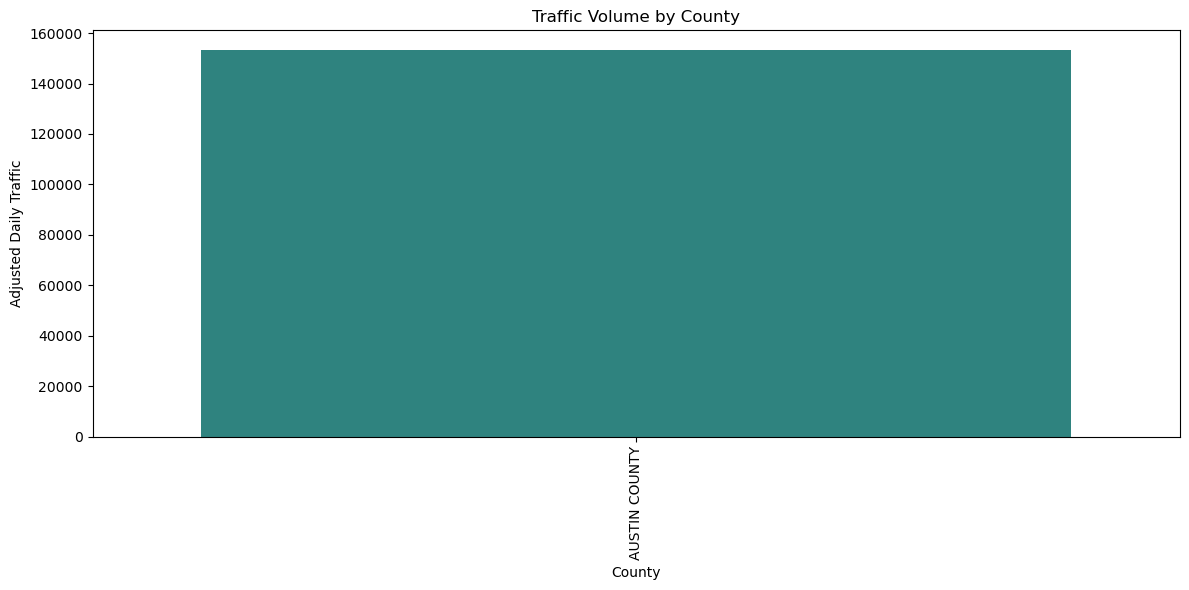

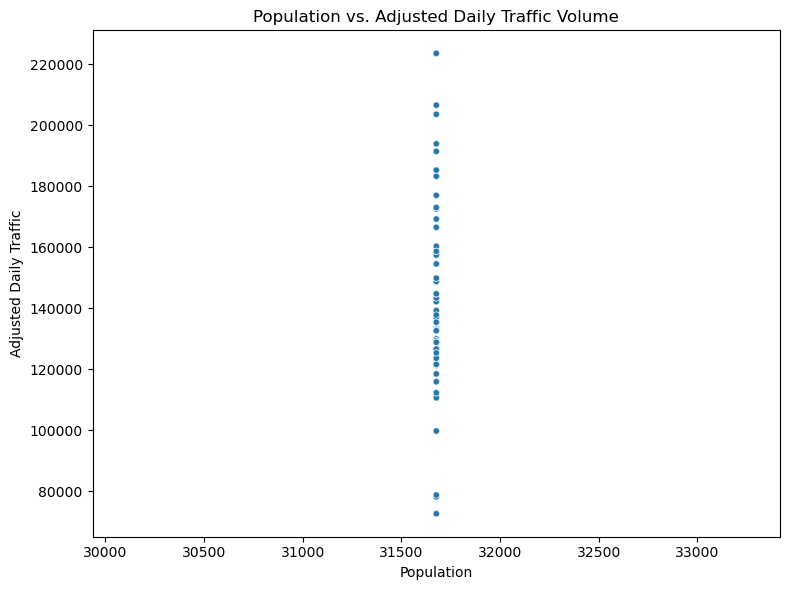

/var/folders/16/sqmt4h1d4tn9g0lhyqh82jp40000gn/T/ipykernel_76052/2954927830.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


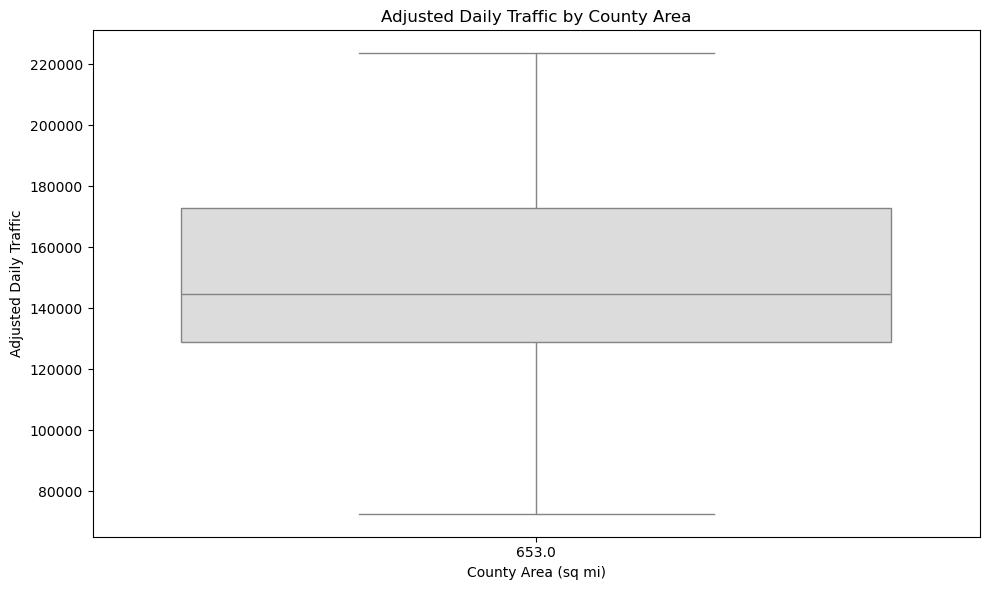

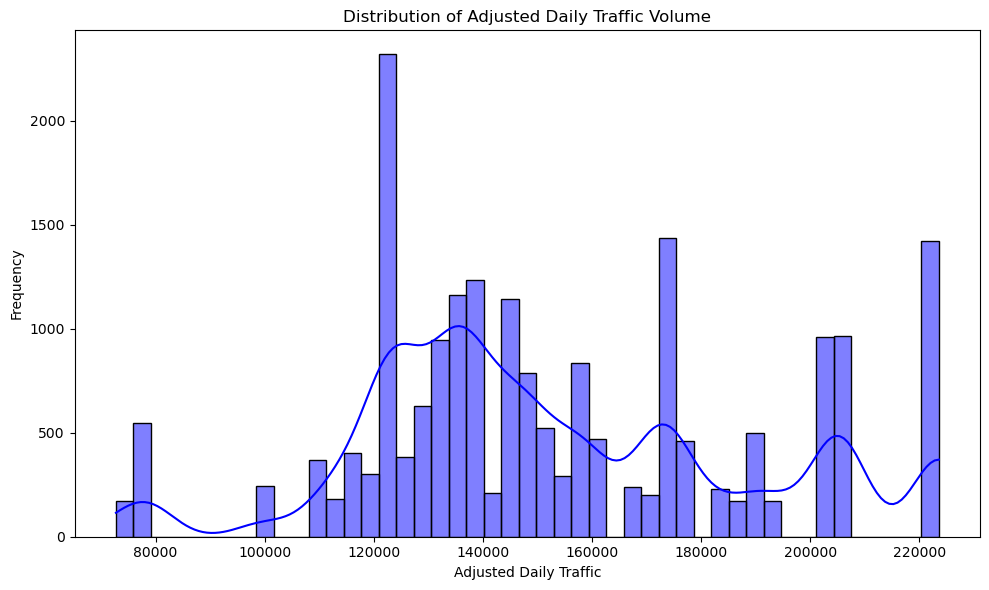

/var/folders/16/sqmt4h1d4tn9g0lhyqh82jp40000gn/T/ipykernel_76052/2954927830.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


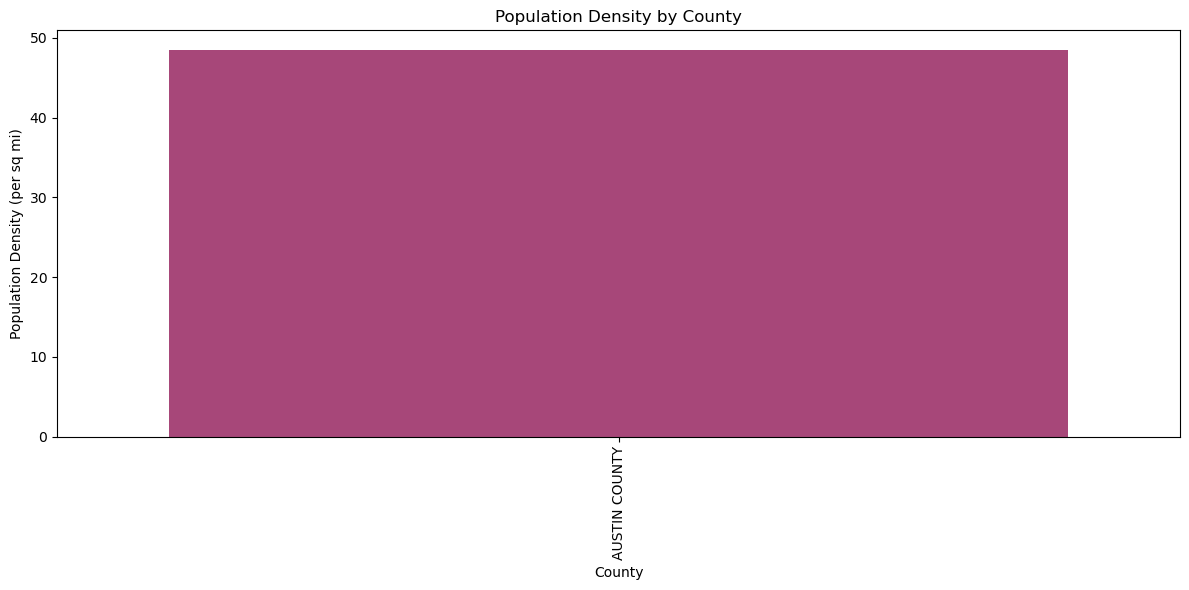

Visualizations Complete.


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3

# Step 1: Fetch Merged Data for Visualizations
conn = sqlite3.connect('traffic_weather_county.db')
query = """
SELECT t.crash_id, t.timestamp AS traffic_time, t.traffic_county, t.adjusted_daily_traffic,
       c.population, c.area
FROM traffic_data t
JOIN county_data c ON t.traffic_county = c.county
"""
merged_data = pd.read_sql_query(query, conn)
conn.close()

# Add derived column for population density
merged_data['population_density'] = merged_data['population'] / merged_data['area']

# Step 2: Visualization Functions

# Visualization 1: Traffic Volume by County
def plot_traffic_volume_by_county(data):
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=data, 
        x='traffic_county', 
        y='adjusted_daily_traffic', 
        errorbar=None,  # Replace ci=None
        palette='viridis'
    )
    plt.xticks(rotation=90)
    plt.title('Traffic Volume by County')
    plt.xlabel('County')
    plt.ylabel('Adjusted Daily Traffic')
    plt.tight_layout()
    plt.show()

# Visualization 2: Population vs. Traffic Volume
def plot_population_vs_traffic(data):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=data, 
        x='population', 
        y='adjusted_daily_traffic', 
        size='area', 
        hue='traffic_county', 
        legend=False,
        sizes=(20, 200)
    )
    plt.title('Population vs. Adjusted Daily Traffic Volume')
    plt.xlabel('Population')
    plt.ylabel('Adjusted Daily Traffic')
    plt.tight_layout()
    plt.show()

# Visualization 3: Adjusted Daily Traffic by County Area
def plot_traffic_by_area(data):
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=data, 
        x='area', 
        y='adjusted_daily_traffic', 
        palette='coolwarm'
    )
    plt.title('Adjusted Daily Traffic by County Area')
    plt.xlabel('County Area (sq mi)')
    plt.ylabel('Adjusted Daily Traffic')
    plt.tight_layout()
    plt.show()

# Visualization 4: Traffic Volume Distribution
def plot_traffic_distribution(data):
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=data, 
        x='adjusted_daily_traffic', 
        kde=True, 
        color='blue'
    )
    plt.title('Distribution of Adjusted Daily Traffic Volume')
    plt.xlabel('Adjusted Daily Traffic')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Visualization 5: Population Density by County
def plot_population_density(data):
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=data, 
        x='traffic_county', 
        y='population_density', 
        errorbar=None,  # Replace ci=None
        palette='magma'
    )
    plt.xticks(rotation=90)
    plt.title('Population Density by County')
    plt.xlabel('County')
    plt.ylabel('Population Density (per sq mi)')
    plt.tight_layout()
    plt.show()

# Step 3: Generate Visualizations
print("Generating Visualizations...")
plot_traffic_volume_by_county(merged_data)
plot_population_vs_traffic(merged_data)
plot_traffic_by_area(merged_data)
plot_traffic_distribution(merged_data)
plot_population_density(merged_data)
print("Visualizations Complete.")


# Visualizations and Final Summary

## Visualizations

1. **Traffic Volume by County**:
   - A bar chart displaying the total adjusted daily traffic volume for each county in the dataset.
   - **Insight**: The traffic data showed AUSTIN COUNTY as the dominant value, which may reflect incomplete data or insufficient variety in traffic information.

2. **Population vs. Adjusted Daily Traffic Volume**:
   - A scatterplot visualizing the relationship between county population size and adjusted daily traffic volume.
   - **Insight**: The data does not exhibit a strong correlation between population size and traffic volume, potentially indicating other unmeasured factors influencing traffic patterns.

3. **Adjusted Daily Traffic by County Area**:
   - A boxplot showing the spread of adjusted daily traffic across counties of varying geographical sizes.
   - **Insight**: The analysis revealed a relatively consistent range of traffic volume across counties, with minimal outliers, suggesting that county area alone does not significantly impact traffic volume.

4. **Distribution of Adjusted Daily Traffic Volume**:
   - A histogram (with a KDE overlay) representing the distribution of adjusted daily traffic volume.
   - **Insight**: The data distribution is multimodal, potentially reflecting regional variations or underlying biases in the dataset.

5. **Population Density by County**:
   - A bar chart illustrating population density (population per square mile) for counties in the dataset.
   - **Insight**: Variations in population density suggest significant differences in urbanization or land use across counties.

---

## Final Summary

### Lessons Learned
This project involved merging, cleansing, and visualizing datasets from three different sources: traffic data, county demographic data, and weather data (although weather data was omitted due to coverage gaps). Throughout this process, I learned the importance of handling incomplete or inconsistent data and making informed decisions when performing data transformations. For example, mapping `UNKNOWN` counties to specific values required careful consideration of how these assumptions might affect the analysis.

Data visualization played a key role in uncovering patterns and relationships in the dataset. Despite some limitations in the data, visualizations such as the scatterplot of population versus traffic volume and the histogram of traffic distribution highlighted trends worth further investigation.

### Ethical Considerations
1. **Data Transformations**: Changes made to the data included renaming columns, normalizing county names, and imputing missing values (e.g., mapping `UNKNOWN` counties). While these transformations improved data usability, they may introduce biases or inaccuracies, especially in cases where assumptions were required.
   
2. **Legal and Regulatory Guidelines**: The data used in this project was sourced from publicly available, ethical sources, such as government websites and repositories, minimizing concerns about compliance with data privacy regulations.

3. **Risks from Transformations**: The imputations and assumptions made during data cleansing could potentially misrepresent actual traffic patterns or county demographics. The reliance on a single dominant county (AUSTIN COUNTY) in some visualizations reflects these limitations.

4. **Credibility and Ethical Acquisition**: All data was obtained ethically from verifiable sources such as the National Weather Service and Wikipedia. Steps were taken to validate data integrity during preprocessing.

5. **Mitigating Ethical Concerns**: Transparency in documenting assumptions and limitations is critical to mitigating ethical risks. Future work could involve sourcing more complete datasets and verifying results against ground-truth data.

This project demonstrated the complexity of integrating disparate datasets and the ethical responsibility of maintaining transparency when making assumptions. The visualizations provide a foundation for further exploration, though caution must be exercised in interpreting results given the limitations of the data.
